# PoeML_scraper

At the heart of this project is a corpus of poems.  I was unable to find a decent database of modern, short verse, and so decided to scrape my own set of poems from various websites.  Specifically, I scraped poems from:

www.poets.org (mostly relatively modern, sophisticated, complex poems)  
www.poemhunter.com (a wildly diverse set of poems from many different eras)   
www.poetrysoup.com (from here I took the list "Top 100 Famous Poems"  

Of course the rub is that in order to have a well-functioning recommender system, the poems should be stylistically "suited" to the task.  Really that requires some custom curating:  my taste is not yours, and the "matches" will be more satisfying if the underlying set of poems is palatable.  For this project, I'll end up focusing on modern, short poems and hope for the best, but this is a good example of a project for which at least some "human in the loop" could make a big difference.  

----

## Part I:  www.poets.org


The poems on this site are not directly labeled, but it is possible to browse them by theme.  This script scrolls through all of the themes, and scrapes all the resultant poems.  Some poems belong to more than one theme, and are thus included multiple times in the resulting dataset, once for each theme-word.

The script takes a while to run (on the order of hours.)  For a shorter run time, edit the list of themes and only scrape themes of interest.

**Gather theme labels**

Import statements

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import requests
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
%matplotlib inline

Establish connection to landing page at www.poets.org

In [2]:
main = requests.get("https://www.poets.org/poetsorg/poems")
main_soup = BeautifulSoup(main.text,'lxml') 

Scrape urls of landing page for each theme 

In [3]:
theme_urls = []
for theme in main_soup.find_all('div',class_="themes")[0].find_all('li'):
    theme_url = theme.contents[0].get('href')
    theme_name = theme.get_text()
    theme_urls.append([theme_url,theme_name])
    
df_themes = pd.DataFrame(theme_urls,columns=['url','theme'])
df_themes[0:15]

,url,theme
0,/poetsorg/poems?field_poem_themes_tid=851,Afterlife
1,/poetsorg/poems?field_poem_themes_tid=856,Aging
2,/poetsorg/poems?field_poem_themes_tid=861,Ambition
3,/poetsorg/poems?field_poem_themes_tid=866,America
4,/poetsorg/poems?field_poem_themes_tid=871,American Revolution
5,/poetsorg/poems?field_poem_themes_tid=1691,Americana
6,/poetsorg/poems?field_poem_themes_tid=876,Ancestry
7,/poetsorg/poems?field_poem_themes_tid=881,Anger
8,/poetsorg/poems?field_poem_themes_tid=886,Animals
9,/poetsorg/poems?field_poem_themes_tid=1531,Anxiety


*Audio* as actually not a theme...it just means that there is an audio recording of this poem.  Since this fact is irrelevant for this classification scheme, we'll drop that row.  Ditto for *Public domain*.

In [6]:
df_themes = df_themes.loc[(df_themes.theme != 'Audio') & (df_themes.theme != 'Public Domain'),:]

*Optional:* Scrape url of landing page for each occasion. (I didn't actually use these, but someone might want to, so I've kept the code here.)

In [7]:
occasion_urls = []
for occasion in main_soup.find_all('div',class_="occasions")[0].find_all('li'):
    occasion_url = occasion.contents[0].get('href')
    occasion_name = occasion.get_text()
    occasion_urls.append([occasion_url,occasion_name])
    
df_occasions = pd.DataFrame(occasion_urls,columns=['url','occasion'])
df_occasions.head()

,url,occasion
0,/poetsorg/poems?field_occasion_tid=476,Anniversary
1,/poetsorg/poems?field_occasion_tid=1671,Asian/Pacific American Heritage Month
2,/poetsorg/poems?field_occasion_tid=484,Autumn
3,/poetsorg/poems?field_occasion_tid=478,Birthdays
4,/poetsorg/poems?field_occasion_tid=1501,Black History Month


**Gather the urls of all poems for each theme**

Now build a master list of poem/theme combinations.  This involves some clever webscraping...for each theme, the results are displayed in a variable number of pages.  We need to figure out the number of pages, and use that number to predict the urls of the pages listing poems ('landing pages').  Once we have these landing pages, we scrape poem info from them.

In order to implement this scheme, we'll need a helper function that returns the individual poem urls from each landing subpage for a given theme.

In [8]:
def get_poem_urls(landing_page_url,theme):
    '''assemble list of poems from a landing page''' 
    year_title_url_poet_theme = []
    main = requests.get(landing_page_url)
    main_soup = BeautifulSoup(main.text,'lxml') 
    odd_entries = main_soup.find_all('tr', class_="odd")
    even_entries = main_soup.find_all('tr', class_="even")
    all_entries = odd_entries + even_entries
    for entry in all_entries:
        year = entry.find('span',class_="date-display-single")
        if year:
            year = year.get_text()
        else:
            year = ''
        titleblob = entry.find('td',class_="views-field views-field-title")
        title = titleblob.a.get_text()
        poem_url = titleblob.a.get('href')
        poet = entry.find('td',class_="views-field views-field-field-first-name")
        if poet.find('a'):
            poet = poet.a.get_text()
        else:
            poet = ''
        year_title_url_poet_theme.append([year,title,poem_url,poet,theme])

    return year_title_url_poet_theme

We'll also need to write to files.  The following functions provide a little error checking to make sure we don't overwrite stuff.

In [9]:
def modify_filename(filename):
    """Add .bak suffix to string """
    return filename + '.bak'

def check_filename(filename):
    """If file that we're going to write to already exists, resave it with a .bak extension"""
    if os.path.isfile(filename):
        filename_mod = modify_filename(filename)
        while os.path.isfile(filename_mod):
            filename_mod = modify_filename(filename_mod)
        os.rename(filename,filename_mod)

Now we'll simply crawl along each theme, and for each theme crawl along each page, and for each page grab all the poem info.  To manage store, we'll write the output for each page to a file as we go along.

<span style="color:red"> Caution:</span> this cell takes a while to run (on the order of half an hour for all themes, but it goes much faster for just a subset.)

In [10]:
# define output file, and rename if it already exists
outfile = 'temp.csv'
check_filename(outfile)

# comment this section out if you want all themes
theme_subset = ['Cities','Nature','Love']
#theme_subset = themes.theme[0:2].tolist()
df_themes = df_themes.loc[df_themes.theme.isin(theme_subset)]

# for each theme....
for index, row in df_themes.iterrows():
    url='https://www.poets.org'+row['url']
    theme = row['theme']
    
    # ...figure out how many pages of output there are
    main = requests.get(url)
    main_soup = BeautifulSoup(main.text,'lxml') 
    npages=main_soup.find('li',class_="pager-item last")
    if npages:
        npages = npages.get_text()
    else:
        npages=main_soup.find('li',class_="pager-last last")
        if npages:
            npages = npages = npages.get_text()
        else:
            npages = 1
    npages_int = int(npages)
    
    # then extract the urls for each page, and print the theme for monitoring
    page_urls = [url, theme]
    print('theme:  ',theme)
    
    # then run over each such page and get the poem urls
    for i in np.arange(1,npages_int):
        page_url = url + "&page=" + str(i)
        page_content = get_poem_urls(page_url,theme)
        df_page = pd.DataFrame(page_content,columns=['year','title','url','author','theme'])
        
        # writing to disc after each page.
        with open(outfile, 'a') as f:
            df_page.to_csv(f, header=False,index=False)

theme:   Cities
theme:   Love
theme:   Nature


Finally, turn all this info into a data frame and save it as a pickle file. 

In [11]:
df_poetsorg_urls = pd.read_csv(outfile,names=['year','title','url','author','theme'])
df_poetsorg_urls.to_pickle('poetsorg_urls.pkl')
df_poetsorg_urls.to_csv('poetsorg_urls.csv',index=False)
df_poetsorg_urls.head()

,year,title,url,author,theme
0,1917.0,Dawn,/poetsorg/poem/dawn-2,John Gould Fletcher,Cities
1,2017.0,Daily Conscription,/poetsorg/poem/daily-conscription,Kyle Dargan,Cities
2,1920.0,Recuerdo,/poetsorg/poem/recuerdo-0,Edna St. Vincent Millay,Cities
3,1917.0,"[Immortal?... No,]",/poetsorg/poem/immortal-no,F. S. Flint,Cities
4,2017.0,from “The Last Bohemian of Avenue A”,/poetsorg/poem/last-bohemian-avenue,Yusef Komunyakaa,Cities


**Drop redundant poems**

Some poems belong to more than one theme.  It makes no sense to re-scrape them.  So we need to re-arrange the data a bit.  We'll gather it by URL, and store themes as a list.

In [12]:
df_grouped_themes=df_poetsorg_urls.groupby('url').apply(lambda x: x.theme.tolist())
df_grouped_themes=pd.DataFrame(df_grouped_themes.reset_index())
df_grouped_themes.columns = ['url','themes']
df_grouped_themes.head()

## if you wish to see which poems were duplicated, run this....

# x = np.zeros(len(df_grouped_themes))
# for i in range(len(df_grouped_themes)):
#     x[i]=len(df_grouped_themes.themes[i])
# idx=np.where(x==2)
# df_grouped_themes.loc[idx[0].tolist(),:]

,url,themes
0,/poetsorg/poem/%E2%80%9Cflying-point%E2%80%9D,[Nature]
1,/poetsorg/poem/%E2%80%9Cyou-are-nearly-every-f...,[Cities]
2,/poetsorg/poem/1-corinthians-134%E2%80%937,[Love]
3,/poetsorg/poem/3-bewildered-landscapes%E2%80%9D,[Nature]
4,/poetsorg/poem/6396-6496,[Love]


In [13]:
# merge grouped themes back into main themes frame
del df_poetsorg_urls['theme']
df_poetsorg_urls=df_poetsorg_urls.drop_duplicates(subset='url').reset_index(drop=True)
df_poetsorg_urls = pd.merge(df_poetsorg_urls,df_grouped_themes,on='url',how='inner')
df_poetsorg_urls.head()

,year,title,url,author,themes
0,1917.0,Dawn,/poetsorg/poem/dawn-2,John Gould Fletcher,"[Cities, Nature]"
1,2017.0,Daily Conscription,/poetsorg/poem/daily-conscription,Kyle Dargan,[Cities]
2,1920.0,Recuerdo,/poetsorg/poem/recuerdo-0,Edna St. Vincent Millay,[Cities]
3,1917.0,"[Immortal?... No,]",/poetsorg/poem/immortal-no,F. S. Flint,"[Cities, Nature]"
4,2017.0,from “The Last Bohemian of Avenue A”,/poetsorg/poem/last-bohemian-avenue,Yusef Komunyakaa,[Cities]


**Gather the poems from each poem url**

OK, now we've assembled an exhaustive list of poem urls, we can scrape the poems themselves!  This will really take a long time:  there are over 10000 labelled poems.  (*Suggestion:  run the cell just before you go to bed and check it in the morning.*)

The script writes poems to file every so often.  You can adjust how often it writes and prints out progress information. 



In [14]:
# define batch size for writing to file and printing progress
batchsize=10
outfile = 'poetsorg_poems.csv'
check_filename(outfile)

# create a dataframe to hold the poems, indexed by url
df_poetsorg_poems = pd.DataFrame(columns=['url','poem'])
df_poetsorg_poems['url']=df_poetsorg_urls['url']
df_poetsorg_poems.reset_index(inplace=True,drop=True)
jobsize = np.ceil(len(df_poetsorg_poems)/batchsize)

# iterate over all poems
counter = 0
for row in df_poetsorg_poems.itertuples():
    
    # connecting poem page
    url = 'https://www.poets.org' + row.url
    main = requests.get(url)
    main_soup = BeautifulSoup(main.text,'lxml') 

    # finding the relevant div snippet, printing error message if we can't find it
    poem_div=main_soup.find('div',class_="field field-name-body field-type-text-with-summary field-label-hidden")
    if poem_div:
        text = poem_div.get_text(" ")
    else:
        print('missed {}'.format(url))
        
    # store poem in dataframe
    df_poetsorg_poems.loc[row.Index,'poem'] = text
    
    counter+=1
    #every batch, write to file and print out counter 
    if np.mod(counter,batchsize)==0:
        with open(outfile, 'a') as f:
            df_poetsorg_poems[counter-batchsize:counter].to_csv(f, header=False,index=False)
        print("completed {:1.0f} of {:1.0f} batches. ".format(counter/batchsize,jobsize))

# one last print statement to get residuals
with open(outfile, 'a') as f:
            df_poetsorg_poems[counter-np.mod(counter,batchsize):counter+1].to_csv(f, header=False,index=False)

completed 1 of 83 batches. 
completed 2 of 83 batches. 
completed 3 of 83 batches. 
completed 4 of 83 batches. 
completed 5 of 83 batches. 
completed 6 of 83 batches. 
completed 7 of 83 batches. 
completed 8 of 83 batches. 
completed 9 of 83 batches. 
completed 10 of 83 batches. 
completed 11 of 83 batches. 
completed 12 of 83 batches. 
completed 13 of 83 batches. 
completed 14 of 83 batches. 
completed 15 of 83 batches. 
completed 16 of 83 batches. 
completed 17 of 83 batches. 
completed 18 of 83 batches. 
completed 19 of 83 batches. 
completed 20 of 83 batches. 
completed 21 of 83 batches. 
completed 22 of 83 batches. 
completed 23 of 83 batches. 
completed 24 of 83 batches. 
completed 25 of 83 batches. 
completed 26 of 83 batches. 
completed 27 of 83 batches. 
completed 28 of 83 batches. 
completed 29 of 83 batches. 
completed 30 of 83 batches. 
completed 31 of 83 batches. 
completed 32 of 83 batches. 
completed 33 of 83 batches. 
completed 34 of 83 batches. 
completed 35 of 83 batc

We've already written these poems to a CSV file, but let's join the poems to the authors, titles, etc, and re-write the whole thing to include a header.  Let's also store the dataframe a pickle file.   Note that linebreaks are saved.  These might be useful for subsequent formatting, but will need to be cleaned out for processing.

In [15]:
df = pd.merge(df_poetsorg_urls,df_poetsorg_poems, on='url',left_index=True,right_index=True,how='inner')
df.head()

,year,title,url,author,themes,poem
0,1917.0,Dawn,/poetsorg/poem/dawn-2,John Gould Fletcher,"[Cities, Nature]","Above the east horizon, The great red flower o..."
1,2017.0,Daily Conscription,/poetsorg/poem/daily-conscription,Kyle Dargan,[Cities],“We can no longer afford that particular roman...
2,1920.0,Recuerdo,/poetsorg/poem/recuerdo-0,Edna St. Vincent Millay,[Cities],"We were very tired, we were very merry— We..."
3,1917.0,"[Immortal?... No,]",/poetsorg/poem/immortal-no,F. S. Flint,"[Cities, Nature]","Immortal?... No, they cannot be, these people,..."
4,2017.0,from “The Last Bohemian of Avenue A”,/poetsorg/poem/last-bohemian-avenue,Yusef Komunyakaa,[Cities],Here’s the End of the World mobile with its sh...


In [23]:
# save the poems
df.to_pickle('poetsorg_poems_full.pkl')
df.to_csv('poetsorg_poems_full.csv',index=False)

In [22]:
df.head()

,year,title,url,author,themes,poem
0,1917.0,Dawn,/poetsorg/poem/dawn-2,John Gould Fletcher,"[Cities, Nature]","Above the east horizon, The great red flower o..."
1,2017.0,Daily Conscription,/poetsorg/poem/daily-conscription,Kyle Dargan,[Cities],“We can no longer afford that particular roman...
2,1920.0,Recuerdo,/poetsorg/poem/recuerdo-0,Edna St. Vincent Millay,[Cities],"We were very tired, we were very merry— We..."
3,1917.0,"[Immortal?... No,]",/poetsorg/poem/immortal-no,F. S. Flint,"[Cities, Nature]","Immortal?... No, they cannot be, these people,..."
4,2017.0,from “The Last Bohemian of Avenue A”,/poetsorg/poem/last-bohemian-avenue,Yusef Komunyakaa,[Cities],Here’s the End of the World mobile with its sh...


## Part III:  clean the data!

Drop any record with missing values.  

In [24]:
df = df.dropna(axis=0,subset=['poem','themes'],how='any')
len(df)

822

Remove carriage returns.

In [28]:
df = df.replace({r'\r|\n': ' '}, regex=True)
df.poem = df.poem.str.strip()
df.poem.head()

0    Above the east horizon, The great red flower o...
1    “We can no longer afford that particular roman...
2    We were very tired, we were very merry—   We h...
3    Immortal?... No, they cannot be, these people,...
4    Here’s the End of the World mobile with its sh...
Name: poem, dtype: object

Generate and store length information for each poem

(array([ 9.,  5., 10., 12., 31., 33., 31., 35., 31., 38., 62., 59., 64.,
        38., 42., 25., 25., 18., 19., 17.]),
 array([  7.  ,  16.55,  26.1 ,  35.65,  45.2 ,  54.75,  64.3 ,  73.85,
         83.4 ,  92.95, 102.5 , 112.05, 121.6 , 131.15, 140.7 , 150.25,
        159.8 , 169.35, 178.9 , 188.45, 198.  ]),
 <a list of 20 Patch objects>)

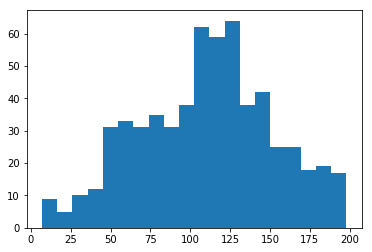

In [32]:
# calculate length for each poem, and plot it in a histogram
maxlength=200
df['lengths'] = df.poem.str.split(' ').apply(lambda x: len(x))
plt.hist(df.lengths.loc[df.lengths<maxlength],20)

Store the clean data

In [33]:
df.to_csv('poetsorg_clean.csv',index=False)
df.to_pickle('poetsorg_clean.pkl')

In [34]:
df.loc[df.lengths<500,:].count()

year       784
title      790
url        790
author     784
themes     790
poem       790
lengths    790
dtype: int64